Лабораторная работа № 7 по Нейроинформатике

Автоассоциативные сети с узким горлом

Выполнила: Тимофеева Наталья М8О-408Б-19

Вариант № 8

In [316]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from tqdm import tqdm
from matplotlib.widgets import Slider, Button
from torch import optim
import torch.utils.data.dataloader

In [317]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dictionary = pickle.load(fo, encoding='latin1')
    return dictionary

Функция для загрузки датасета

In [318]:
def load_train_data(path, needed_label):
    data_dictionary = unpickle(path)
    images = data_dictionary['data']
    labels = data_dictionary['labels']
    dataset = []
    for image, label in zip(images, labels):
        if label == needed_label:
            image = np.asarray(image, dtype=np.float32)
            image = (image - 127.5) / 127.5
            dataset += [(image, image)]
    return dataset

In [320]:
core_data = None

Параметры модели

In [323]:
epochs = 50
width = 32
height = 32
dim_1 = width * height * 3
dim_2 = int(dim_1 / 2)
dim_3 = int(dim_1 / 8)

In [324]:
encoder = nn.Sequential(
    nn.Linear(in_features=dim_1, out_features=dim_2),
    nn.ReLU(),
    nn.Linear(in_features=dim_2, out_features=dim_3),
)

In [325]:
decoder = nn.Sequential(
    nn.Linear(in_features=dim_3, out_features=dim_2),
    nn.ReLU(),
    nn.Linear(in_features=dim_2, out_features=dim_1),
    nn.Tanh(),
)

In [326]:
optimizer_enc = optim.Adam(encoder.parameters(), lr=1e-3)
optimizer_dec = optim.Adam(decoder.parameters(), lr=1e-3)

Добавляем в датасет нужные нам картинки (в данном случае - корабли)

In [327]:
train_data = []
train_data += load_train_data(path='cifar-10-batches-py/data_batch_1', needed_label=8)
train_data += load_train_data(path='cifar-10-batches-py/data_batch_2', needed_label=8)
train_data += load_train_data(path='cifar-10-batches-py/data_batch_3', needed_label=8)
train_data += load_train_data(path='cifar-10-batches-py/data_batch_4', needed_label=8)
train_data += load_train_data(path='cifar-10-batches-py/data_batch_5', needed_label=8)
np.random.shuffle(train_data)

In [328]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

In [329]:
print('dim_1: %d, dim_2: %d, dim_3: %d, samples: %d' % (dim_1, dim_2, dim_3, len(train_data)))

dim_1: 3072, dim_2: 1536, dim_3: 384, samples: 5000


Обучаем

In [330]:
encoder.train()

Sequential(
  (0): Linear(in_features=3072, out_features=1536, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1536, out_features=384, bias=True)
)

In [331]:
decoder.train()

Sequential(
  (0): Linear(in_features=384, out_features=1536, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1536, out_features=3072, bias=True)
  (3): Tanh()
)

In [332]:
train_loss = []
start_time = timer()
for i in range(epochs):
    pbar = tqdm(enumerate(train_loader))
    for j, (input, output_gt) in pbar:
        output_enc = encoder(input)
        output_dec = decoder(output_enc)
        crit = nn.MSELoss()
        loss = torch.sqrt(crit(output_gt, output_dec))
        train_loss += [loss.item()]
        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()
        loss.backward()
        optimizer_enc.step()
        optimizer_dec.step()
        pbar.set_description('%d. loss: %f' % (i + 1, train_loss[-1]))
end_time = timer()

1. loss: 0.224675: : 40it [00:04,  8.33it/s]
2. loss: 0.196523: : 40it [00:05,  7.99it/s]
3. loss: 0.182502: : 40it [00:05,  7.44it/s]
4. loss: 0.209097: : 40it [00:05,  7.80it/s]
5. loss: 0.203979: : 40it [00:05,  7.85it/s]
6. loss: 0.161094: : 40it [00:05,  7.78it/s]
7. loss: 0.158519: : 40it [00:05,  7.76it/s]
8. loss: 0.143580: : 40it [00:05,  7.86it/s]
9. loss: 0.145133: : 40it [00:05,  7.63it/s]
10. loss: 0.155023: : 40it [00:05,  7.57it/s]
11. loss: 0.146745: : 40it [00:05,  7.61it/s]
12. loss: 0.146516: : 40it [00:05,  6.79it/s]
13. loss: 0.139975: : 40it [00:05,  7.18it/s]
14. loss: 0.151509: : 40it [00:05,  7.84it/s]
15. loss: 0.124382: : 40it [00:05,  7.95it/s]
16. loss: 0.133508: : 40it [00:05,  7.80it/s]
17. loss: 0.130204: : 40it [00:06,  5.99it/s]
18. loss: 0.127807: : 40it [00:06,  5.90it/s]
19. loss: 0.143672: : 40it [00:06,  6.05it/s]
20. loss: 0.121971: : 40it [00:06,  6.48it/s]
21. loss: 0.120503: : 40it [00:05,  7.26it/s]
22. loss: 0.120137: : 40it [00:05,  7.20it/

In [333]:
print('Время обучения = {0} секунд'.format(int(end_time - start_time)))
print('Количество эпох = {0}'.format(epochs))

Время обучения = 266 секунд
Количество эпох = 50


In [334]:
encoder.eval()

Sequential(
  (0): Linear(in_features=3072, out_features=1536, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1536, out_features=384, bias=True)
)

In [335]:
decoder.eval()

Sequential(
  (0): Linear(in_features=384, out_features=1536, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1536, out_features=3072, bias=True)
  (3): Tanh()
)

Функция делает из вектора картинку

In [381]:
def plain_to_image(image, width=32, height=32):
    image = (image + 1) / 2
    image = np.reshape(image, (3, height, width))
    image = np.transpose(image, [1, 2, 0])
    return image

Функция для отрисовки результатов

In [380]:
def draw_pictires(axes_get, axes_out, axes_mod, encoder, decoder, data):
    global core_data
    image = data[np.random.randint(low=0, high=len(data))][0]
    encoder_out = encoder(torch.from_numpy(image)).detach().numpy()
    decoder_out = decoder(torch.from_numpy(encoder_out)).detach().numpy()
    core_data = np.copy(encoder_out)
    mod_out = core_data + np.random.rand(384)
    mod_out = decoder(torch.from_numpy(mod_out).to(torch.float32)).detach().numpy()
    axes_get.set_array(plain_to_image(image))
    axes_out.set_array(plain_to_image(decoder_out))
    axes_mod.set_array(plain_to_image(mod_out))
    plt.draw()

Отрисовываем результаты

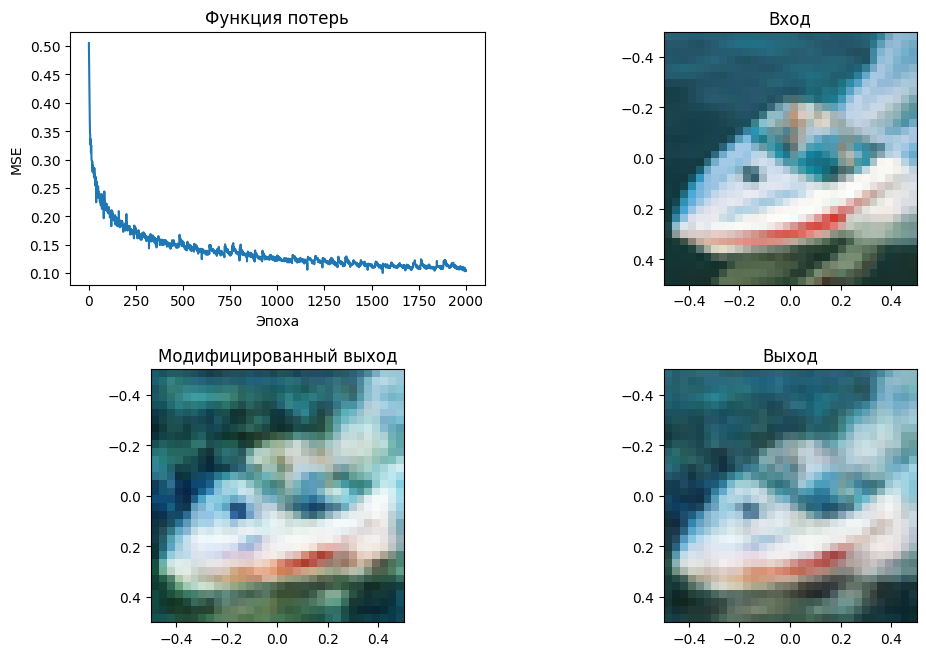

In [379]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6.5))
fig.tight_layout(h_pad = 4, w_pad = 4)

axes[0, 0].set_title('Функция потерь')
axes[0, 0].set_xlabel('Эпоха')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].plot(train_loss)

axes[0, 1].set_title('Вход')
axes[0, 1].set_aspect(1)
ax_gt = axes[0, 1].imshow([[0]])

axes[1, 0].set_title('Модифицированный выход')
axes[1, 0].set_aspect(1)
ax_mod = axes[1, 0].imshow([[0]])

axes[1, 1].set_title('Выход')
axes[1, 1].set_aspect(1)
ax_out = axes[1, 1].imshow([[0]])

features = np.random.randint(low=0, high=dim_3, size=3)

draw_pictires(ax_gt, ax_out, ax_mod, encoder, decoder, train_data)